<a href="https://colab.research.google.com/github/yamac0/IE423/blob/main/task6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='#475468'> User Segmentation:</font>
### <font color='#475468'> Can you segment users by purchasing behavior?</font>

## Initialize

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale

## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dfSale =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/sales/sales.csv')

In [5]:
dfSale.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Prepare Data

Adding new columns like PurchaseCount and PricePerPurchase and aggreagating datas uniqely for every user

In [6]:
# Aggregate by customer ID
dfUser = (dfSale.groupby('User_ID').agg({"Gender":"first", "Age":"first", "Occupation":"first", "City_Category":"first", "Stay_In_Current_City_Years":"first", "Marital_Status":"first", "Purchase":"sum"}))

dfUser["PurchaseCount"] = dfSale.groupby("User_ID").agg({"Purchase":"count"})
dfUser["PricePerPurchase"] = dfUser['Purchase']/dfUser['PurchaseCount']


dfUser

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,PurchaseCount,PricePerPurchase
User_ID,,,,,,,,,
1000001,F,0-17,10,A,2,0,334093,35,9545.514286
1000002,M,55+,16,C,4+,0,810472,77,10525.610390
1000003,M,26-35,15,A,3,0,341635,29,11780.517241
1000004,M,46-50,7,B,2,1,206468,14,14747.714286
1000005,M,26-35,20,A,1,1,821001,106,7745.292453
...,...,...,...,...,...,...,...,...,...
1006036,F,26-35,15,B,4+,1,4116058,514,8007.894942
1006037,F,46-50,1,C,4+,0,1119538,122,9176.540984
1006038,F,55+,1,C,2,0,90034,12,7502.833333


In [7]:
# Scale data
X = dfUser[['PurchaseCount', 'PricePerPurchase', 'Purchase']].copy()
X[X.columns] = scale(X[X.columns])
X.head()

,PurchaseCount,PricePerPurchase,Purchase
User_ID,,,
1000001,-0.544633,-0.012342,-0.562679
1000002,-0.152772,0.506247,-0.057807
1000003,-0.600613,1.170245,-0.554686
1000004,-0.740563,2.740251,-0.697937
1000005,0.117798,-0.964877,-0.046648


Note that previously we had a 'Target' column named 'y' which is what we used to train our models on.  In those models our learning was *Supervised* by the previously defined Target values.  However, in this dataset, there is no indication of prior grouping of the customers, so we are going to have to learn something about the data in an *Unsupervised Learning* manner.

Text(0, 0.5, 'PurchaseCount')

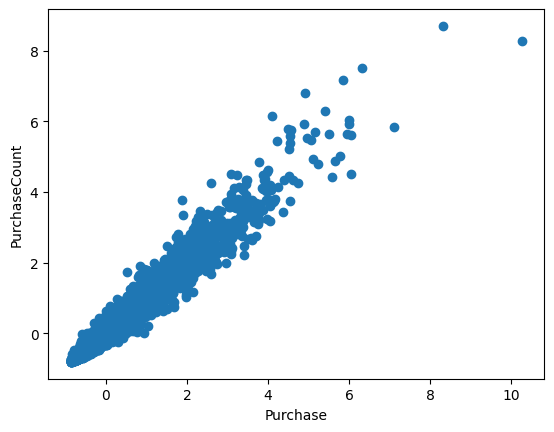

In [8]:
# Visualize scatterplot

plt.scatter(X['Purchase'],X['PurchaseCount'])
plt.xlabel('Purchase')
plt.ylabel('PurchaseCount')

In order to segment the users, let's start by a random assignment and then *Iteratively* improve the result.

### K-Means Clustering

In order to segment the users, let's start by randomly assigning them to 'n' clusters.  Thereafter, each user is reassigned to another cluster that it is closer to, and this process is repeated until no more improvements are possible.  This method is known as **K-Means Clustering**.

In [9]:
# Build k-Means Clustering model

from sklearn.cluster import KMeans

mdlKmcUsr = KMeans(n_clusters=3, random_state=1)
mdlKmcUsr.fit(X)
kMeans_labels = mdlKmcUsr.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'K-Means Clustering')

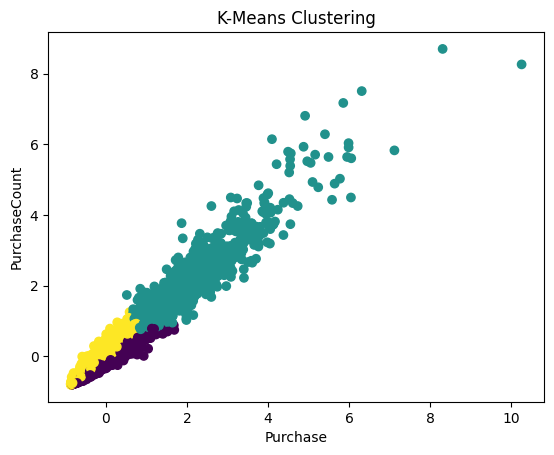

In [10]:
# Display k-Means cluster on scatter plot

plt.scatter(X['Purchase'],X['PurchaseCount'],c=kMeans_labels)
plt.xlabel('Purchase')
plt.ylabel('PurchaseCount')
plt.title('K-Means Clustering')

Since we don't have a ground-truth to calculate an accuracy score (like we did in Supervised Learning), we will need to measure how similar an object is to its own cluster (cohesion) compared to other clusters (separation).  This is known as the **Silhouette Score**. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [15]:
# Evaluate quality of clusters
from sklearn.metrics import silhouette_score

silhouette_score(X, mdlKmcUsr.labels_)

0.40035253272637766

In [14]:
# Function for K-means Clustering
def cluster_kMeans(X, k):
    mdlKmcUsr = KMeans(n_clusters=k, random_state=1)
    mdlKmcUsr.fit(X)
    kMeans_labels = mdlKmcUsr.labels_
    kMeans_sil_score = silhouette_score(X, mdlKmcUsr.labels_)
    return (kMeans_labels, kMeans_sil_score)

In [ ]:
# Iterate over different values of k to determine best silhouette score

for k in [2, 3, 4, 5, 6]:
    kMeans_labels, kMeans_sil_score = cluster_kMeans(X,k)
    print('k: ',k,'\t\t', 'Silhouette Score: ', kMeans_sil_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k:  2 		 Silhouette Score:  0.5490001626193649


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k:  3 		 Silhouette Score:  0.40035253272637766


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k:  4 		 Silhouette Score:  0.4256935549190382


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k:  5 		 Silhouette Score:  0.3770132165393068


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k:  6 		 Silhouette Score:  0.37782640122207245


The best cluster size seems to be '2' at which the Silhouette Score is 0.55.

Let's see if we can improve the user segmentation by starting with each user in its own cluster and then *Hierarchically* grouping them together.

### Hierarchical Clustering

**Hierarchical clustering**, as the name suggests is an algorithm that builds hierarchy of clusters. This algorithm starts with all the data points assigned to a cluster of their own. Then two nearest clusters are merged into the same cluster. In the end, this algorithm terminates when there is only a single cluster left.

In [13]:
# Generate linkages between data points
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X, 'ward')

Text(0.5, 1.0, 'Hierarchical Clustering')

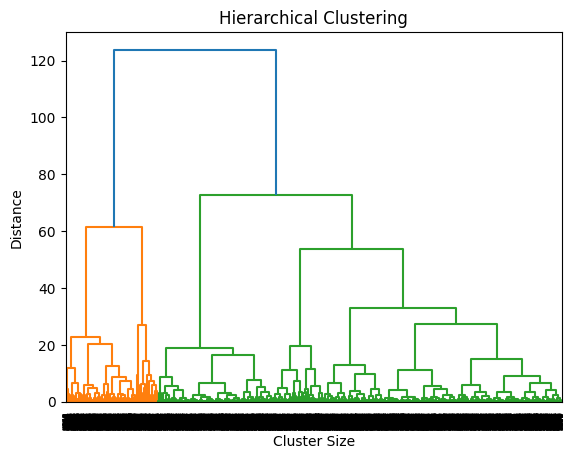

In [ ]:
# Visualize Dendrogram of Clusters

hierarchy.dendrogram(Z)
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering')

The greater the y-axis distance, the more spaced apart the clusters are.  So, the dendrogram shows 3 clusters are ideal, but 2 clusters is okay too.  Having said that, when building a hierarchical clustering model, we do provide K as an input so it doesn't have to build the full dendrogram (especially for large datasets).

In [24]:
# Build Hierarchical Clustering model
from sklearn.cluster import AgglomerativeClustering

mdlHrcUsr = AgglomerativeClustering(n_clusters=2)
mdlHrcUsr.fit(X)
hClust_labels = mdlHrcUsr.labels_

In [23]:
silhouette_score(X, mdlHrcUsr.labels_)

0.5117203716890377

Text(0.5, 1.0, 'Hierarchical Clustering')

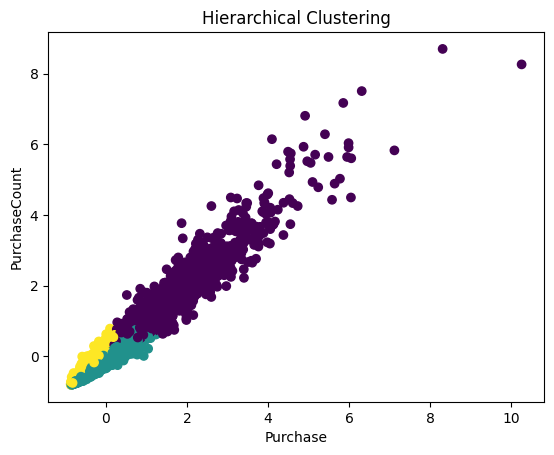

In [ ]:
# Display Hierarchical cluster on scatter plot

plt.scatter(X['Purchase'],X['PurchaseCount'],c=hClust_labels)
plt.xlabel('Purchase')
plt.ylabel('PurchaseCount')
plt.title('Hierarchical Clustering')

In [ ]:
# Function for Hierarchical Clustering
def cluster_hierarchy(X, k):
    mdlHrcUsr = AgglomerativeClustering(n_clusters=k)
    mdlHrcUsr.fit(X)
    hClust_labels = mdlHrcUsr.labels_
    hClust_sil_score = silhouette_score(X, mdlHrcUsr.labels_)
    return (hClust_labels, hClust_sil_score)

In [ ]:
# Iterate over different values of k to determine best silhouette score

for k in [2, 3, 4, 5, 6]:
    hClust_labels, hClust_sil_score = cluster_hierarchy(X,k)
    print('k: ',k,'\t\t', 'Silhouette Score: ', hClust_sil_score)

k:  2 		 Silhouette Score:  0.5117203716890377
k:  3 		 Silhouette Score:  0.3392271796211749
k:  4 		 Silhouette Score:  0.3457747670253613
k:  5 		 Silhouette Score:  0.34610250062079906
k:  6 		 Silhouette Score:  0.3293769977313021


Even in Hierarchical Clustering, the ideal cluster size is '2', which is reassuring.  However, the cluster labels seem to be slightly better in K-Means Clustering with a Silhouette Score of 0.55 over the score of 0.51.

Let's take a step back, and think about how we as human beings group data points together.  We typically look for dense regions and draw a boundary around it.  We also ignore anomalous datapoints far away from dense regions.  Such models are known as density based models... ideal for data that follows patterns.

### DBScan Clustering and Anomaly Detection

DBScan stands for Density-Based Spatial Clustering of Applications with Noise.  Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

In [ ]:
# Build DBScan model

from sklearn.cluster import DBSCAN

mdlDbsUsr = DBSCAN(eps=0.2)
mdlDbsUsr.fit(X)
dbscan_labels = mdlDbsUsr.labels_

In [ ]:
silhouette_score(X, dbscan_labels)

0.37065749732525455

In [ ]:
# calculate number of clusters
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_clusters

12

In [ ]:
# calculate number of anomalies
dbscan_anomalies = list(dbscan_labels).count(-1)
dbscan_anomalies

176

Text(0.5, 1.0, 'DBScan Clustering')

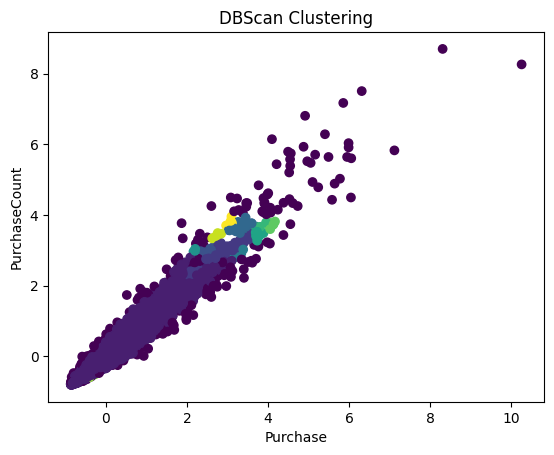

In [ ]:
# Display DBScan cluster on scatter plot

plt.scatter(X['Purchase'],X['PurchaseCount'],c=dbscan_labels)
plt.xlabel('Purchase')
plt.ylabel('PurchaseCount')
plt.title('DBScan Clustering')

In [ ]:
# Function for DBScan Clustering

def cluster_dbscan(X, e):
    mdlDbsUsr = DBSCAN(eps=e)
    mdlDbsUsr.fit(X)
    dbscan_labels = mdlDbsUsr.labels_
    dbscan_sil_score = silhouette_score(X, dbscan_labels)

    # count number of clusters and noise points
    dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    dbscan_anomalies = list(dbscan_labels).count(-1)
    return(dbscan_clusters, dbscan_anomalies, dbscan_sil_score)

In [ ]:
# Iterate over different values of eps to determine best silhouette score

for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    dbscan_clusters, dbscan_anomalies, dbscan_sil_score = cluster_dbscan(X, eps)
    print('eps: ',eps,'\t', 'Clusters: ', dbscan_clusters, '\t', 'Noise: ', dbscan_anomalies, '\t', 'Silhouette Score: ', dbscan_sil_score)

eps:  0.1 	 Clusters:  32 	 Noise:  641 	 Silhouette Score:  -0.16964472754500837
eps:  0.2 	 Clusters:  12 	 Noise:  176 	 Silhouette Score:  0.37065749732525455
eps:  0.3 	 Clusters:  3 	 Noise:  77 	 Silhouette Score:  0.5474221845907559
eps:  0.4 	 Clusters:  3 	 Noise:  49 	 Silhouette Score:  0.34956751139343795
eps:  0.5 	 Clusters:  2 	 Noise:  31 	 Silhouette Score:  0.6935475887228819
eps:  0.6 	 Clusters:  2 	 Noise:  19 	 Silhouette Score:  0.7192784092429677
eps:  0.7 	 Clusters:  2 	 Noise:  13 	 Silhouette Score:  0.7244702587862684


The highest Silhouette Score in the DBScan model is for a cluster size '1', but it really means there would be 2 clusters where the second cluster is a collection of all the outliers.  However, the Hierarchical Clustering model gave better results which makes sense because in this case we don't have reason to believe that density plays a big role.

Even though we may not choose DBScan in this case, it is still useful in determining outliers.  

## Takeaways

* Introduced unsupervised learning problems to cluster data points using *K-Means Clustering* and *Hierarchical Clustering*
* Explored a different method of clustering and anomaly detection using density via *DBScan*
* Evaluated the performance of such unsupervised learning models via the *Silhouette Score* due to the absence of ground-truth information

*   Best score was in the DBScan method with 0.72 and after that 0.55 with k-means clustering(3 clusters) and finally 0.51 with hierarchical clustering.

